<h1 style="text-align: center">
Deep Learning HW4 </br>
VAE and CVAE
</h1>


### Full Name: Kian Kamandi
### Student ID: 401211041

# Import necessary libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import random
import torchvision

In [2]:
device = 'cpu'

# Define the MNIST dataset and data loader

In [3]:
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
test_loader = DataLoader(train_dataset, batch_size=64)

100%|██████████| 9912422/9912422 [00:00<00:00, 83524946.05it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 30065945.35it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 26883304.56it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 5739839.94it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# Data Visualization

In [4]:
# Function to display an image
def show_image(image, figsize=(5, 5)):
    plt.figure(figsize=figsize)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()

# Function to show random images from each class
def show_random_images_from_each_class(dataset, num_images_per_class=4, figsize=(10, 20)):
    class_labels = list(range(10))  
    fig, axs = plt.subplots(len(class_labels), num_images_per_class, figsize=figsize) 

    for i, label in enumerate(class_labels):
        class_indices = [idx for idx, target in enumerate(dataset.targets) if target == label]
        random_indices = random.sample(class_indices, num_images_per_class)

        for j, idx in enumerate(random_indices):
            image, target = dataset[idx]
            axs[i, j].imshow(image[0], cmap='gray')
            axs[i, j].set_title(f"Class {label}", fontsize=16)
            axs[i, j].axis('off')
            axs[i, j].set_aspect('equal')  
            axs[i, j].grid(True)

    plt.tight_layout()
    plt.show()

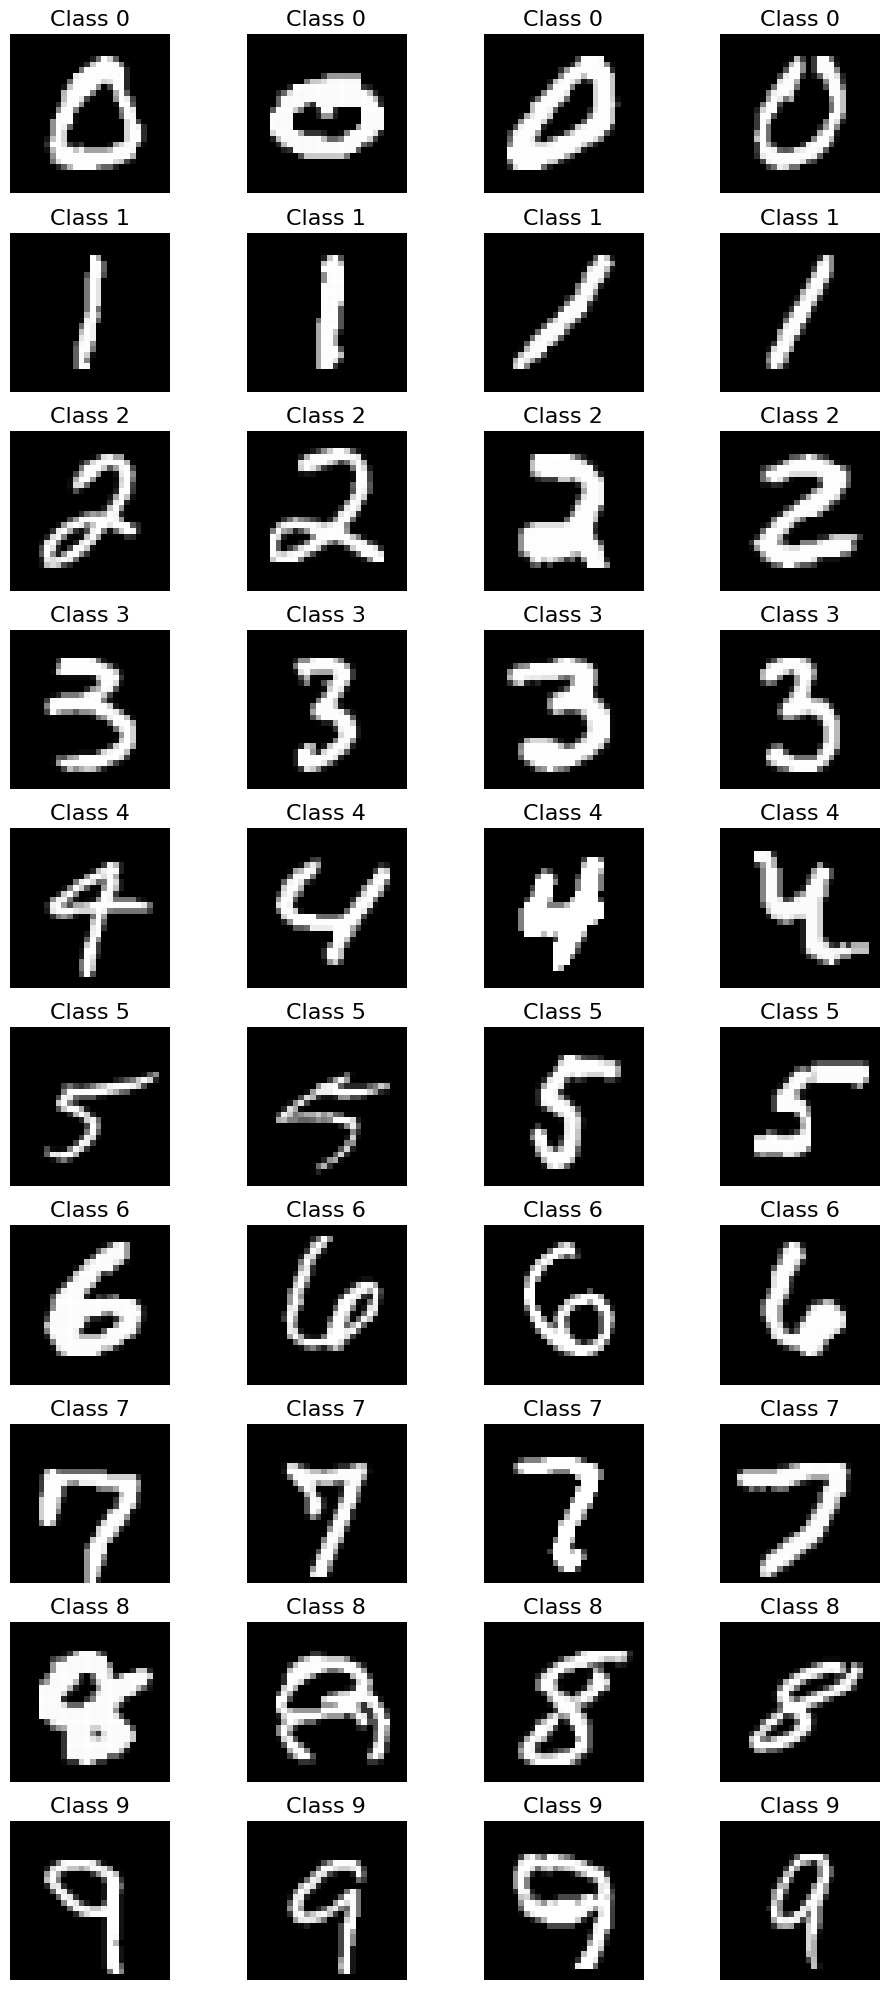

In [5]:
# Use the function to show random images from each class
show_random_images_from_each_class(train_dataset, num_images_per_class=4)

Exercise: Variational Autoencoders (VAE) and Conditional Variational Autoencoders (CVAE)

with MLP Architectures

In this exercise, we'll explore Variational Autoencoders (VAE) and Conditional VAE (CVAE) using PyTorch.

We will implement these models using Multi-Layer Perceptrons (MLP) 

Let's get started!

# 1) VAE --> MLP

In [69]:
# Define a simple VAE class with MLP architecture

class VAE_MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE_MLP, self).__init__()
        # TODO: Define the architecture of the encoder and decoder
        self.encoder = nn.Sequential(
            # TODO: Add layers for the encoder
            nn.Flatten(),
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
           )
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        self.decoder = nn.Sequential(
            # TODO: Add layers for the decoder
            nn.ReLU(),
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)
        )

    def reparameterize(self, mu, logvar):
        # TODO: Implement the reparameterization trick
        sigma = torch.exp(logvar/2)
        epsilon = torch.randn((sigma.shape))

        z = mu + sigma * epsilon
        return z

    def forward(self, x):
        # TODO: Implement the forward pass
        out = self.encoder(x)
        mu = self.fc_mu(out)
        logvar = self.fc_logvar(out)
        z = self.reparameterize(mu, logvar)
        out = self.decoder(z)

        return out, mu, logvar, z


In [70]:
# Define VAE loss function

def vae_loss(recon, data, mu, logvar):
    # TODO: Implement the reconstruction loss
    reconstruction_loss = F.mse_loss(recon, data, reduction='sum')
    #print(f'reconstruction_loss = {reconstruction_loss}')
    # TODO: Implement the KL divergence loss
    kl_divergence = 0.5 * torch.sum((torch.exp(logvar) + mu.pow(2) - torch.ones_like(mu) - logvar))
    # TODO: Return the total loss as the sum of reconstruction and KL divergence losses
    return (reconstruction_loss + kl_divergence)

In [71]:
# Training Loop - VAE (MLP)
def train_vae_mlp(model, train_loader, num_epochs=10, learning_rate=1e-3):
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    best_loss = float('inf')  # Initialize with a high value
    best_model = None

    for epoch in range(num_epochs):
        print()
        print(50 * "#")
        total_loss = 0
        for batch_idx, (data, _) in enumerate(train_loader):
            # TODO: Forward process
            #print(f'shape of original data:{data.shape}')
            data = data.to(device)
            recon, mu, logvar, _ = model(data)
            # TODO: Flatten the data and recon tensors
            data = torch.flatten(data, start_dim=1)
            recon = torch.flatten(recon, start_dim=1)

            # TODO: Calculate the loss using the vae_loss function
            loss = vae_loss(recon, data, mu, logvar)

            # TODO: Backpropagation and optimization step
            total_loss += loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()


        avg_loss = total_loss / len(train_dataset)
        print(f'VAE-MLP Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss}')

        # Show some sample images after each epoch
        if (epoch + 1) % 1 == 0:
            print("Sample Images:")
            with torch.no_grad():
                num_samples = 6  # Generate num_samples random samples
                sample = torch.randn(num_samples, 2)
                sample = model.decoder(sample).view(num_samples, 1, 28, 28)
                sample = sample.squeeze().cpu()
                fig, axs = plt.subplots(1, num_samples, figsize=(15, 2))
                for i in range(num_samples):
                    axs[i].imshow(sample[i], cmap='gray')
                    axs[i].axis('off')
                plt.show()

        # TODO: Save the best model based on loss
        if avg_loss < best_loss:
            best_loss = avg_loss
            best_model = model  # TODO: Save the model

    # TODO: Save the best model to a file
    torch.save(best_model.state_dict(), 'best_vae_mlp_model.pth')
    print("Best model saved as 'best_vae_mlp_model.pth'")



##################################################
VAE-MLP Epoch [1/25], Loss: 46.722511291503906
Sample Images:


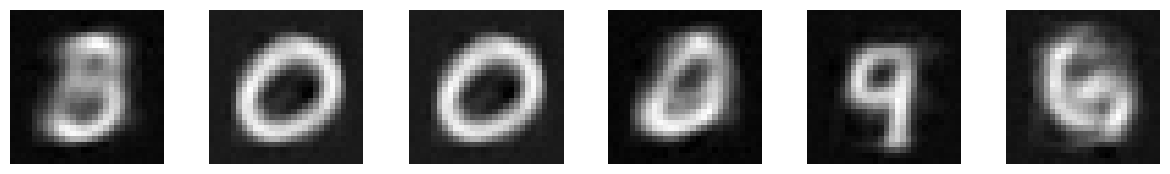


##################################################
VAE-MLP Epoch [2/25], Loss: 41.720542907714844
Sample Images:


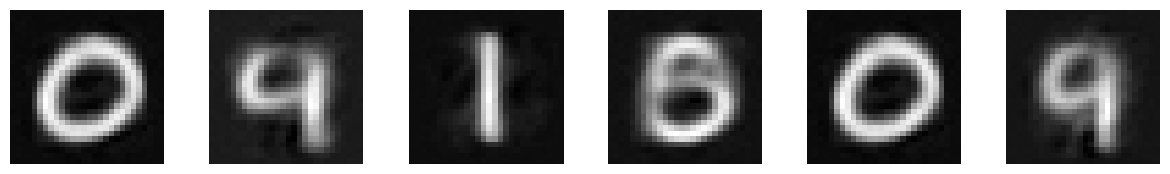


##################################################
VAE-MLP Epoch [3/25], Loss: 40.39134979248047
Sample Images:


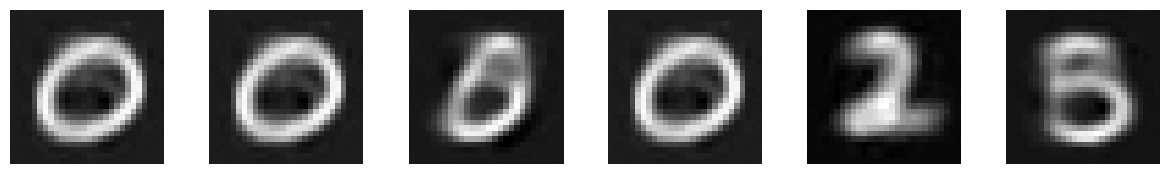


##################################################
VAE-MLP Epoch [4/25], Loss: 39.602745056152344
Sample Images:


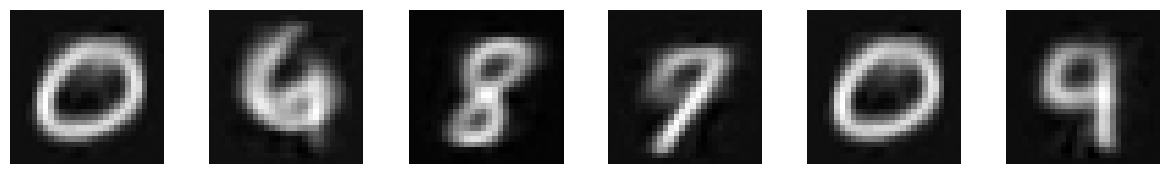


##################################################
VAE-MLP Epoch [5/25], Loss: 39.127174377441406
Sample Images:


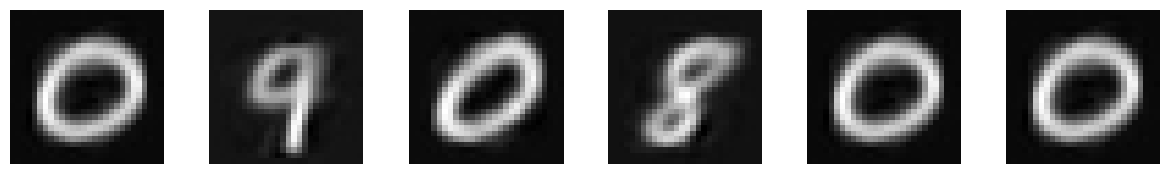


##################################################
VAE-MLP Epoch [6/25], Loss: 38.864662170410156
Sample Images:


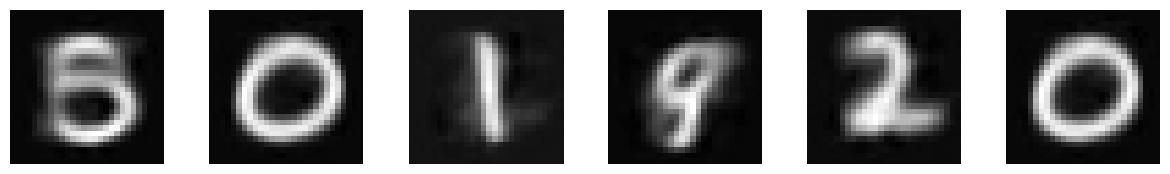


##################################################
VAE-MLP Epoch [7/25], Loss: 38.506263732910156
Sample Images:


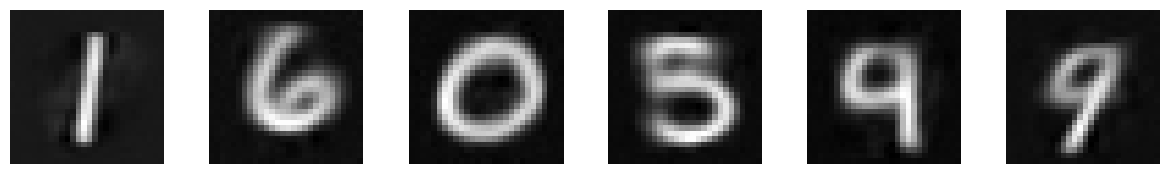


##################################################
VAE-MLP Epoch [8/25], Loss: 38.36497116088867
Sample Images:


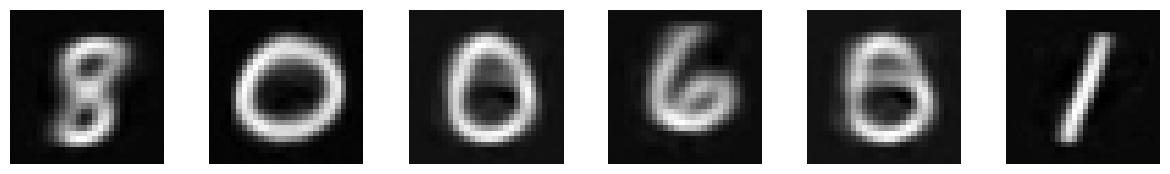


##################################################
VAE-MLP Epoch [9/25], Loss: 38.15468215942383
Sample Images:


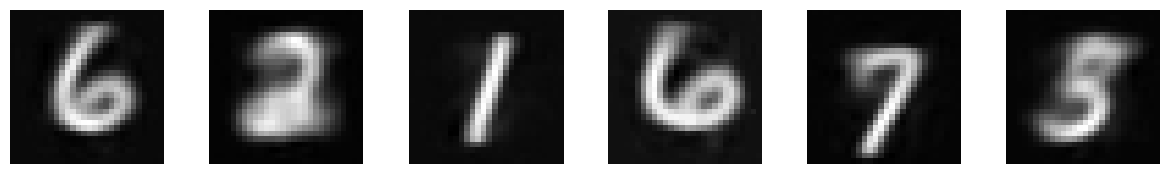


##################################################
VAE-MLP Epoch [10/25], Loss: 38.071617126464844
Sample Images:


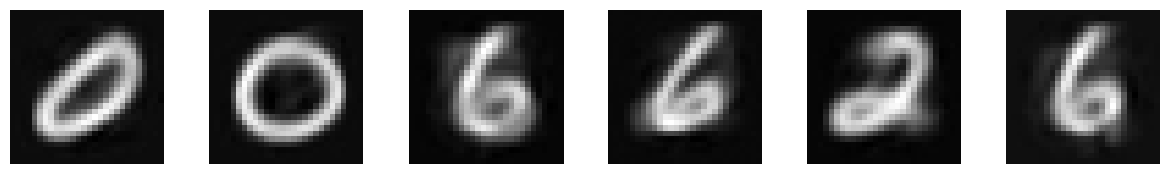


##################################################
VAE-MLP Epoch [11/25], Loss: 38.00441360473633
Sample Images:


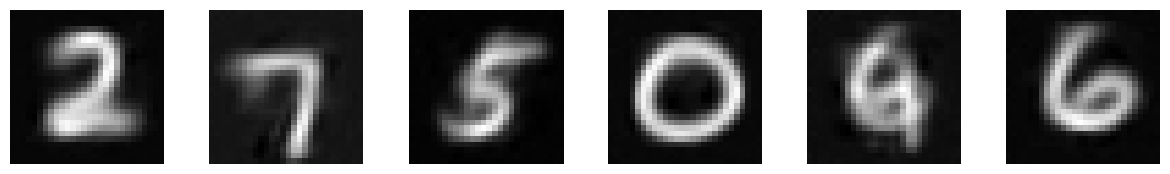


##################################################
VAE-MLP Epoch [12/25], Loss: 37.95306396484375
Sample Images:


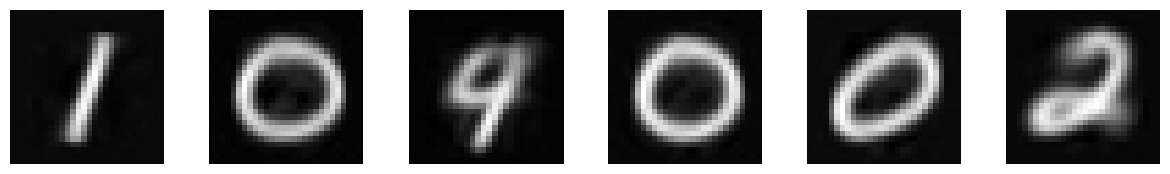


##################################################
VAE-MLP Epoch [13/25], Loss: 37.75910186767578
Sample Images:


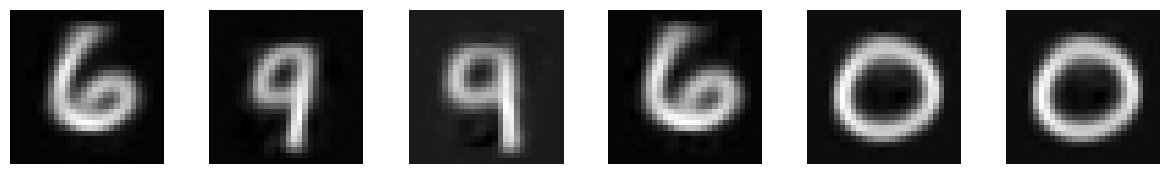


##################################################
VAE-MLP Epoch [14/25], Loss: 37.771995544433594
Sample Images:


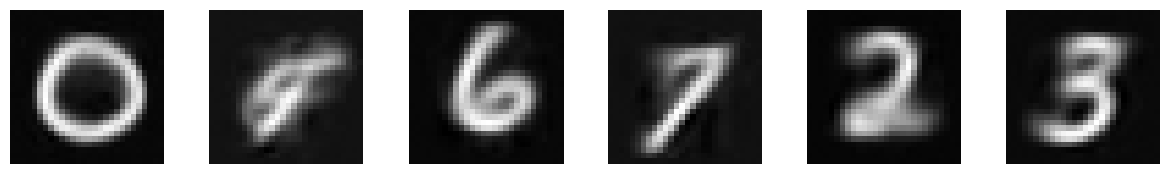


##################################################
VAE-MLP Epoch [15/25], Loss: 37.6786003112793
Sample Images:


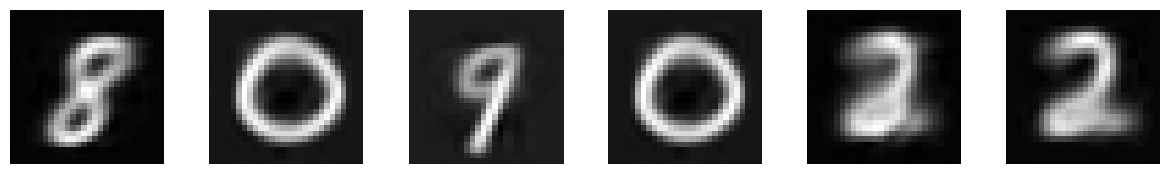


##################################################
VAE-MLP Epoch [16/25], Loss: 37.81871795654297
Sample Images:


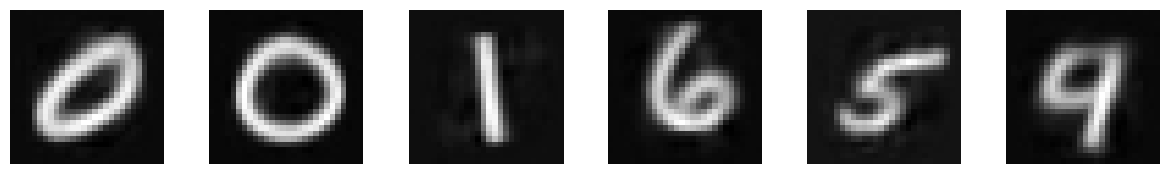


##################################################
VAE-MLP Epoch [17/25], Loss: 37.81531524658203
Sample Images:


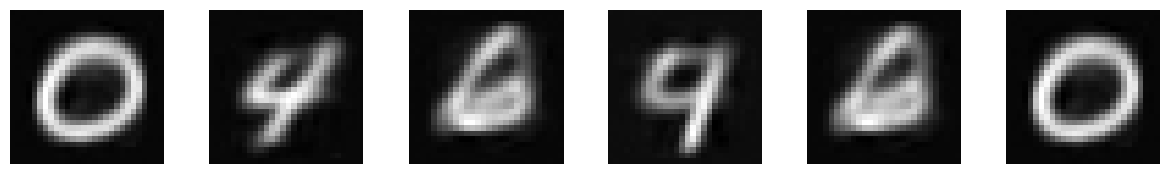


##################################################
VAE-MLP Epoch [18/25], Loss: 37.67978286743164
Sample Images:


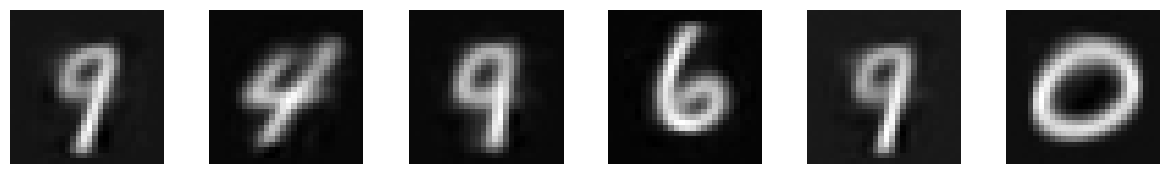


##################################################
VAE-MLP Epoch [19/25], Loss: 37.69232940673828
Sample Images:


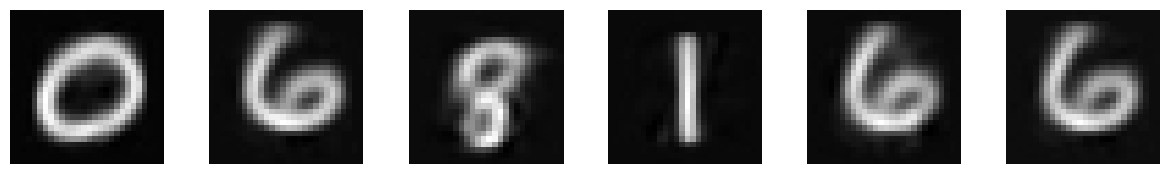


##################################################
VAE-MLP Epoch [20/25], Loss: 37.60110092163086
Sample Images:


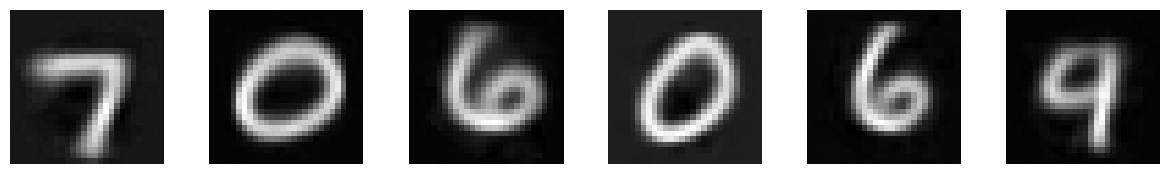


##################################################
VAE-MLP Epoch [21/25], Loss: 37.65462112426758
Sample Images:


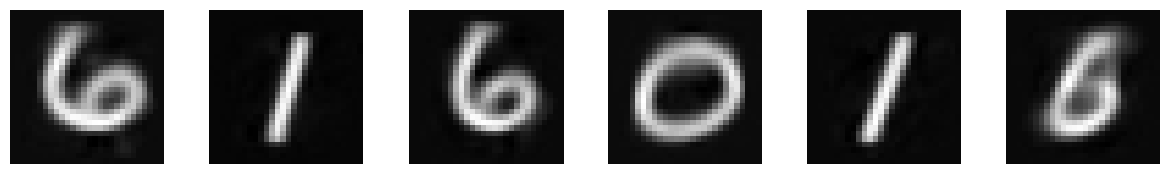


##################################################
VAE-MLP Epoch [22/25], Loss: 37.638893127441406
Sample Images:


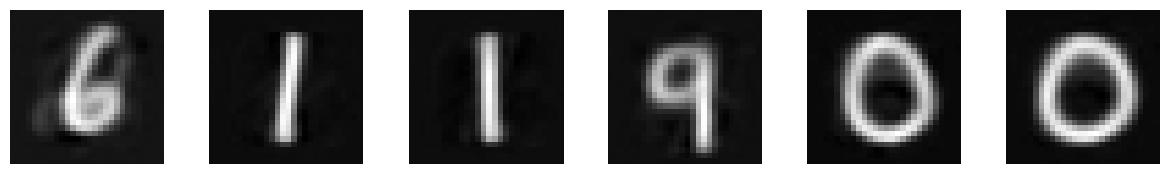


##################################################
VAE-MLP Epoch [23/25], Loss: 37.61449432373047
Sample Images:


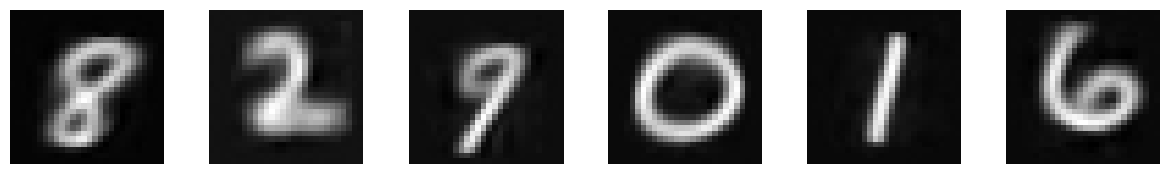


##################################################
VAE-MLP Epoch [24/25], Loss: 37.6821174621582
Sample Images:


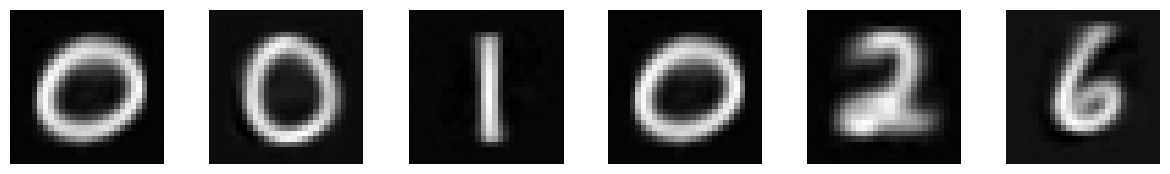


##################################################
VAE-MLP Epoch [25/25], Loss: 37.665748596191406
Sample Images:


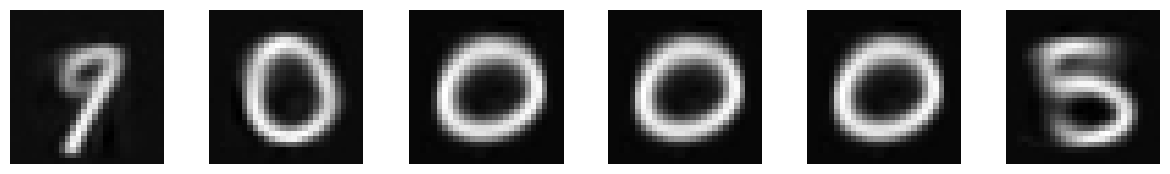

Best model saved as 'best_vae_mlp_model.pth'


In [83]:
torch.manual_seed(42)
# Train VAE-MLP
vae_mlp = VAE_MLP(28*28, 512, 2).to(device)
train_vae_mlp(vae_mlp, train_loader, num_epochs=25, learning_rate=2e-3)

# 2) CVAE --> MLP

In [38]:
# Define a simple CVAE class with MLP architecture

class CVAE_MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, num_classes):
        super(CVAE_MLP, self).__init__()
        # TODO: Define the architecture of the encoder
        self.encoder = nn.Sequential(
            # TODO: Add layers for the encoder
            nn.Linear(input_dim + num_classes, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        self.fc_class = nn.Sequential(nn.Linear(hidden_dim, num_classes),
                         nn.Softmax())

        # TODO: Define the architecture of the decoder
        self.decoder = nn.Sequential(
            # TODO: Add layers for the decoder
            nn.Linear(latent_dim + num_classes, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)
            
        )

    def reparameterize(self, mu, logvar):
        # TODO: Implement the reparameterization trick
        sigma = torch.exp(logvar/2)
        epsilon = torch.randn((sigma.shape))

        z = mu + sigma * epsilon
        return z

    def forward(self, x, y):
        x = x.view(x.size(0), -1)
        y = y.view(y.size(0), -1)

        # TODO: Concatenate x and y before passing them to the encoder
        x = torch.concat([x, y], 1)

        # TODO: Implement the forward pass
        hidden = self.encoder(x)
        mu = self.fc_mu(hidden)
        logvar = self.fc_logvar(hidden)
        z = self.reparameterize(mu, logvar)
        class_logits = self.fc_class(hidden)

        dec_input = torch.concat([z, y], 1)
        reconstructed = self.decoder(dec_input)

        return reconstructed, mu, logvar, class_logits, z


In [39]:
# Define CVAE loss function
def cvae_loss(recon, data, mu, logvar, class_logits, labels):
    # TODO: Flatten the data tensor
    data = torch.flatten(data, start_dim=1)
    recon = torch.flatten(recon, start_dim=1)

    # TODO: Implement the reconstruction loss
    reconstruction_loss = F.mse_loss(recon, data, reduction='sum')

    # TODO: Implement the KL divergence loss
    kl_divergence = 0.5 * torch.sum((torch.exp(logvar) + mu.pow(2) - torch.ones_like(mu) - logvar))

    # TODO: Implement the cross-entropy loss for class prediction
    ce_loss = F.cross_entropy(class_logits, labels.to(torch.float))

    # TODO: Return the total loss as the sum of reconstruction, KL divergence, and cross-entropy losses
    return (reconstruction_loss + kl_divergence + ce_loss)


In [12]:
a = torch.tensor([4, 2])
F.one_hot(a, num_classes=10)

tensor([[0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]])

In [40]:
# Training Loop - CVAE (MLP)
def train_cvae_mlp(model, train_loader, num_epochs=10, learning_rate=1e-3):
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    best_loss = float('inf')  # Initialize with a high value
    best_model = None

    for epoch in range(num_epochs):
        print()
        print(50 * "#")
        total_loss = 0
        for batch_idx, (data, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            # One-hot encode the labels
            labels_one_hot = F.one_hot(labels, num_classes=10)

            # TODO: Forward pass through the model and calculate the loss using cvae_loss
            recon, mu, logvar, class_logits, _ = model(data, labels_one_hot)

            loss = cvae_loss(recon, data, mu, logvar, class_logits, labels_one_hot)

            # TODO: Backpropagation and optimization step
            loss.backward()
            optimizer.step()

            total_loss += loss

        avg_loss = total_loss / len(train_dataset)
        print(f'CVAE-MLP Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss}')

        # Show some sample images after each epoch
        if (epoch + 1) % 1 == 0:
            print("Sample Images:")
            with torch.no_grad():
                num_classes = 10  # Number of classes (0 to 9)
                num_samples_per_class = 1  # One sample per class
                # Generate random samples
                z = torch.randn(num_classes * num_samples_per_class, 2)
                # Generate one-hot encoded class labels
                y = torch.eye(num_classes).repeat(num_samples_per_class, 1)
                # Concatenate the random samples and class labels before passing them to the decoder
                sample = torch.cat([z, y], dim=1)
                sample = model.decoder(sample).view(num_classes * num_samples_per_class, 1, 28, 28)
                sample = sample.squeeze().cpu()
                fig, axs = plt.subplots(1, num_classes, figsize=(15, 2))
                for i in range(num_classes):
                    axs[i].imshow(sample[i], cmap='gray')
                    axs[i].set_title(f"Class {i}", fontsize=16)
                    axs[i].axis('off')
                plt.show()

        # TODO: Save the best model based on loss
        if avg_loss < best_loss:
            best_loss = avg_loss
            best_model = model

    # TODO: Save the best model to a file
    torch.save(best_model.state_dict(), 'best_cvae_mlp_model.pth')
    print("Best model saved as 'best_cvae_mlp_model.pth'")



##################################################
CVAE-MLP Epoch [1/20], Loss: 35.65486145019531
Sample Images:


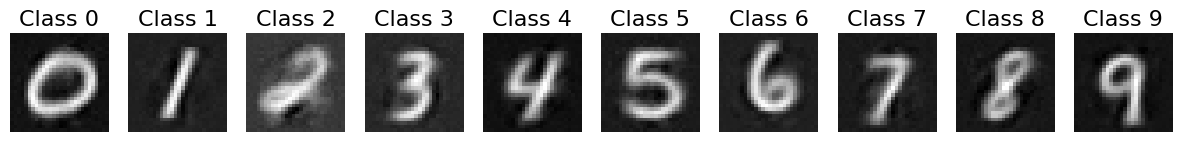


##################################################
CVAE-MLP Epoch [2/20], Loss: 31.92770004272461
Sample Images:


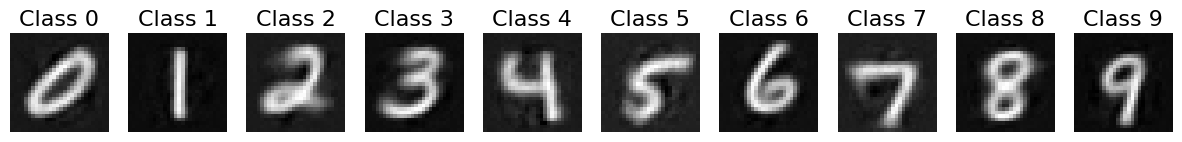


##################################################
CVAE-MLP Epoch [3/20], Loss: 31.187984466552734
Sample Images:


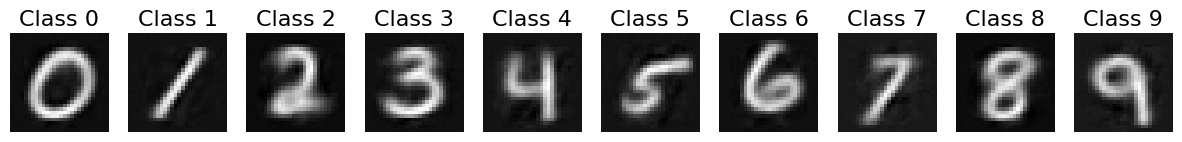


##################################################
CVAE-MLP Epoch [4/20], Loss: 30.8132381439209
Sample Images:


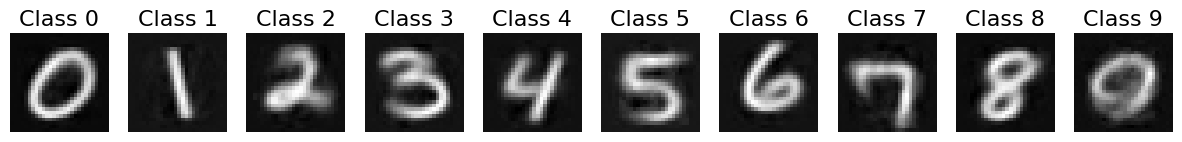


##################################################
CVAE-MLP Epoch [5/20], Loss: 30.561019897460938
Sample Images:


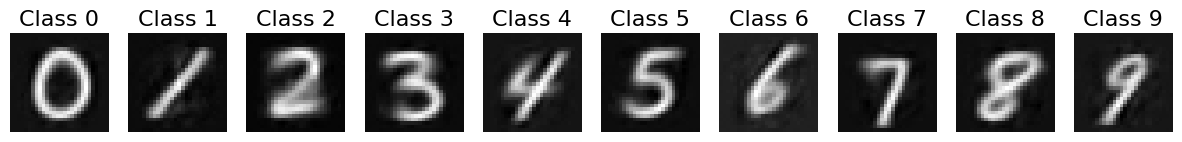


##################################################
CVAE-MLP Epoch [6/20], Loss: 30.37501335144043
Sample Images:


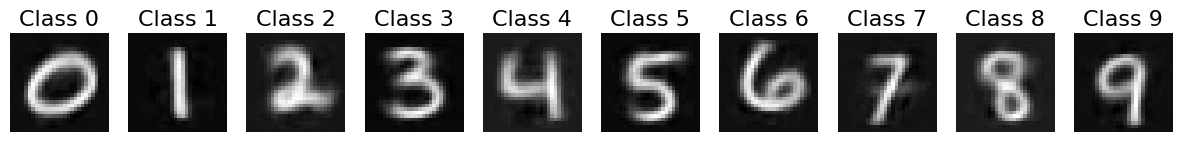


##################################################
CVAE-MLP Epoch [7/20], Loss: 30.20770263671875
Sample Images:


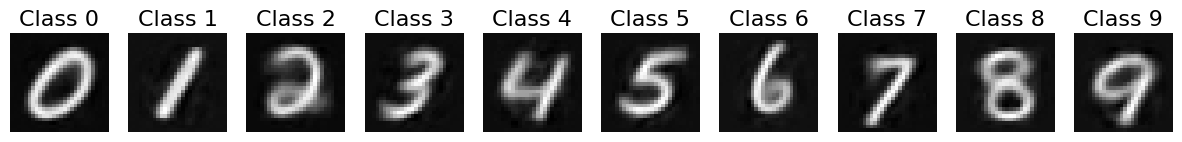


##################################################
CVAE-MLP Epoch [8/20], Loss: 30.089509963989258
Sample Images:


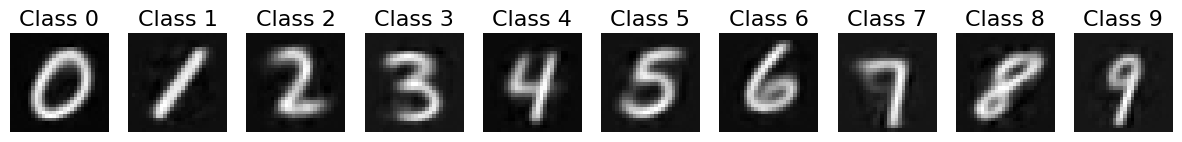


##################################################
CVAE-MLP Epoch [9/20], Loss: 29.978363037109375
Sample Images:


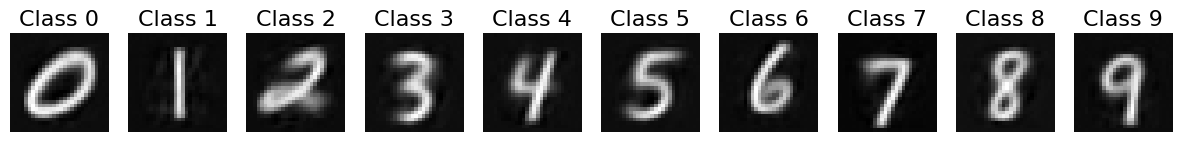


##################################################
CVAE-MLP Epoch [10/20], Loss: 29.85441780090332
Sample Images:


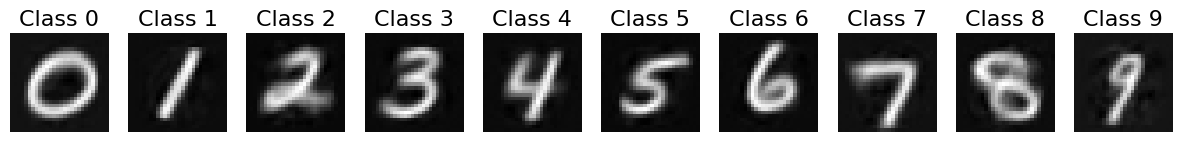


##################################################
CVAE-MLP Epoch [11/20], Loss: 29.78778839111328
Sample Images:


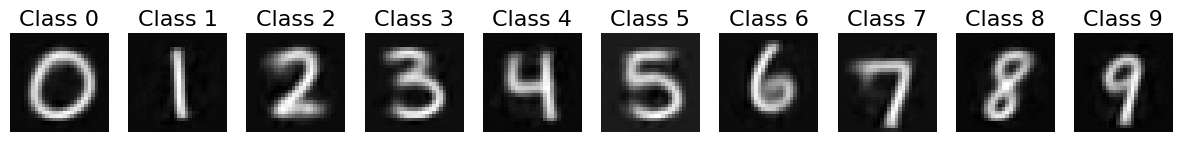


##################################################
CVAE-MLP Epoch [12/20], Loss: 29.698589324951172
Sample Images:


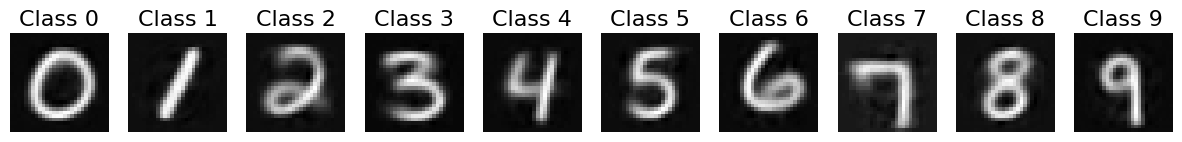


##################################################
CVAE-MLP Epoch [13/20], Loss: 29.626630783081055
Sample Images:


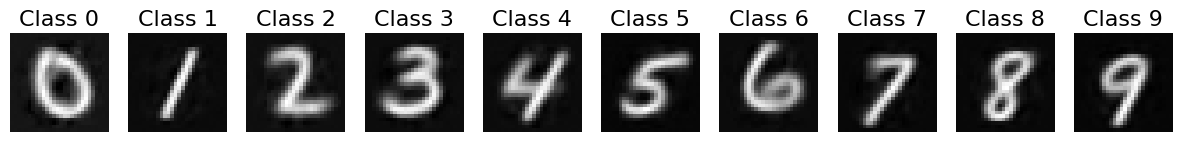


##################################################
CVAE-MLP Epoch [14/20], Loss: 29.550424575805664
Sample Images:


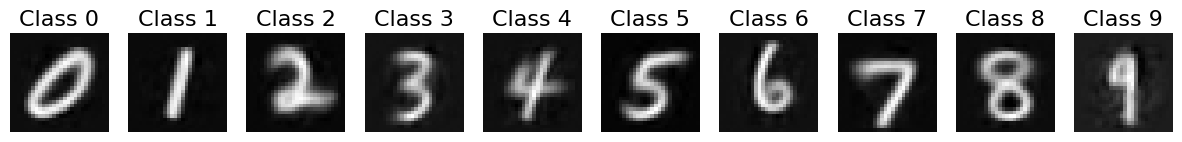


##################################################
CVAE-MLP Epoch [15/20], Loss: 29.494550704956055
Sample Images:


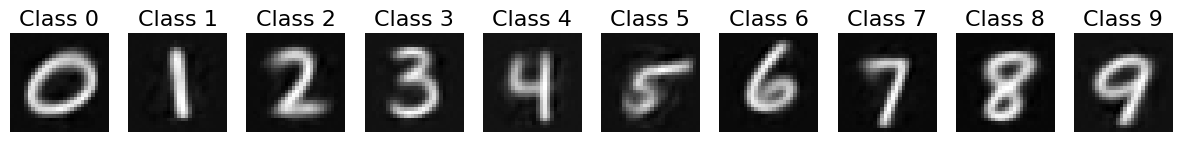


##################################################
CVAE-MLP Epoch [16/20], Loss: 29.451162338256836
Sample Images:


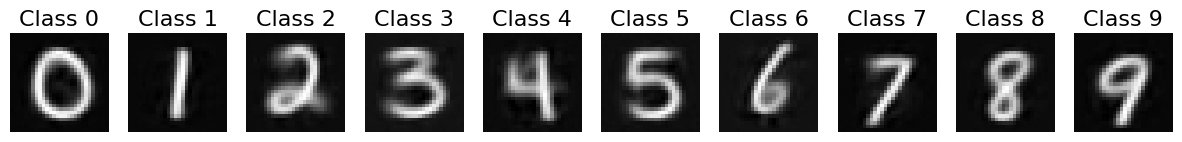


##################################################
CVAE-MLP Epoch [17/20], Loss: 29.408714294433594
Sample Images:


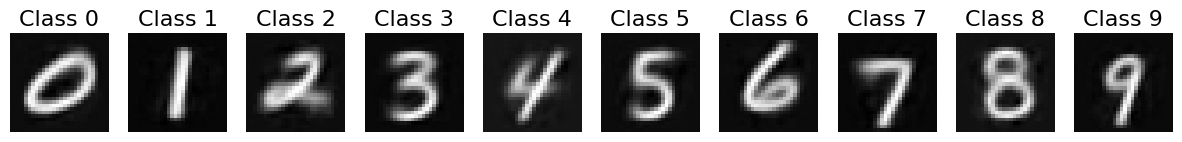


##################################################
CVAE-MLP Epoch [18/20], Loss: 29.345359802246094
Sample Images:


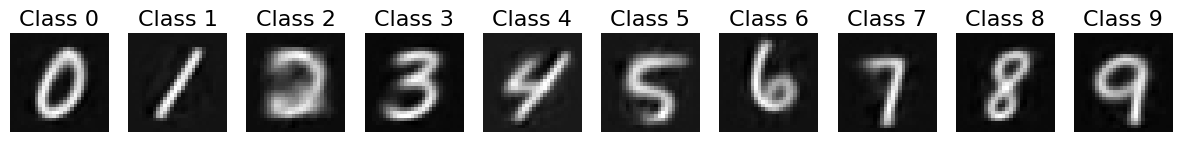


##################################################
CVAE-MLP Epoch [19/20], Loss: 29.3061580657959
Sample Images:


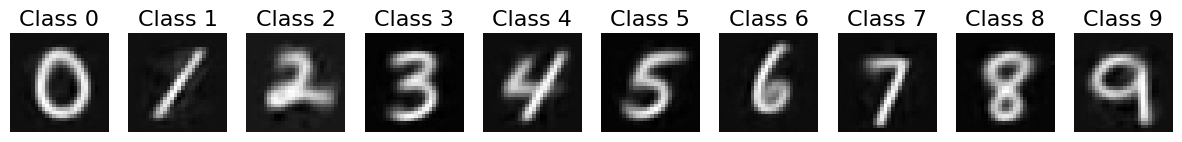


##################################################
CVAE-MLP Epoch [20/20], Loss: 29.270822525024414
Sample Images:


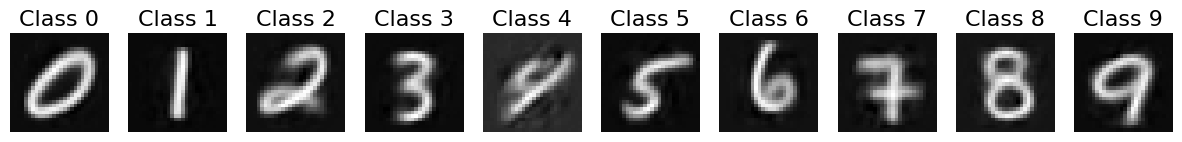

Best model saved as 'best_cvae_mlp_model.pth'


In [43]:
cvae_mlp = CVAE_MLP(28*28, 512, 2, 10)
train_cvae_mlp(cvae_mlp, train_loader, num_epochs=20)

# 3) Visualizing Latent Space Distribution in Two Models

In this section, we will visualize the latent space distribution for two different models:

## Latent Space Distribution:

### VAE (MLP):

1. Visualize the latent space distribution using Multilayer Perceptron (MLP) in VAE model.
2. Analyze the characteristics of the distribution.

### CVAE (MLP):

1. Visualize the latent space distribution using Multilayer Perceptron (MLP) in CVAE model.
2. Analyze the characteristics of the distribution.


Summarize your findings and draw conclusions based on the observed differences in the latent space distribution between VAE (MLP) and CVAE (MLP).


**VAE Latent variables Distribution**

In [84]:
z_list = []
labels = []
model1 = VAE_MLP(28*28, 512, 2)
model1.load_state_dict(torch.load('best_vae_mlp_model.pth'))
model1.eval()
#
with torch.inference_mode():
    for idx, (data, label) in enumerate(iter(test_loader)):
        _, _, _, z = model1(data)
        z_list = z_list + z.tolist()
        labels = labels + label.tolist()
        
        if idx == 50:
            break


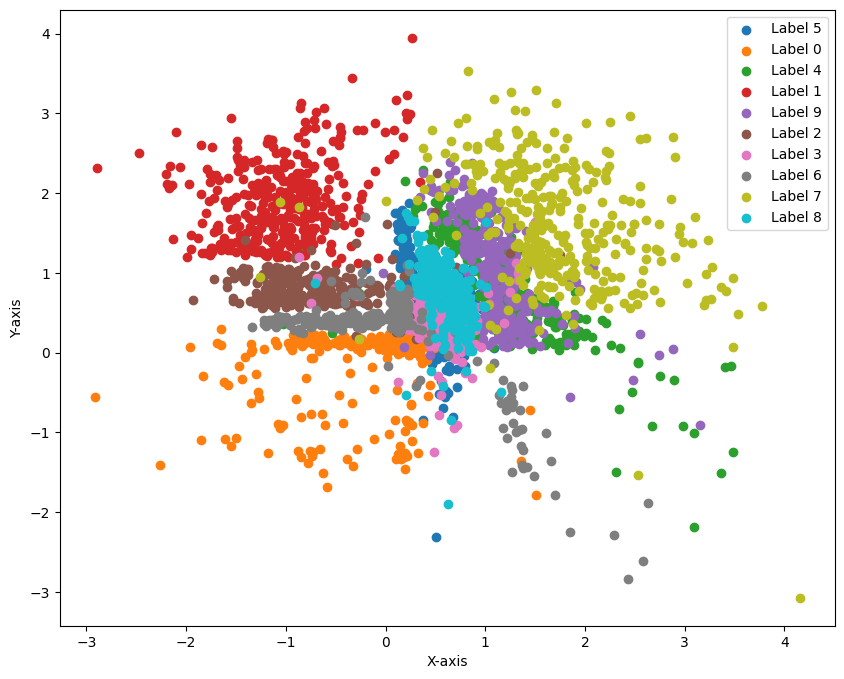

In [85]:
z_labels = {}
for z, label in zip(z_list, labels):
    if label not in z_labels:
        z_labels[label] = []
    z_labels[label].append(z)
    
colors = plt.cm.tab10.colors
plt.figure(figsize=(10, 8))
for label, color in zip(z_labels.keys(), colors):
    label_points = z_labels[label]
    x, y = zip(*label_points)
    plt.scatter(x, y, label=f'Label {label}', color=color)

# Set labels and show the plot
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()
plt.show()

**CVAE Latent variables Distribution**

In [51]:
z_list = []
labels = []
model2 = CVAE_MLP(28*28, 512, 2, 10)
model2.load_state_dict(torch.load('best_cvae_mlp_model.pth'))
model2.eval()

with torch.inference_mode():
    for idx, (data, label) in enumerate(iter(test_loader)):
        labels_one_hot = F.one_hot(label, num_classes=10)
        _, _, _, _, z = model2(data, labels_one_hot)
        z_list = z_list + z.tolist()
        labels = labels + label.tolist()
        
        if idx == 100:
            break

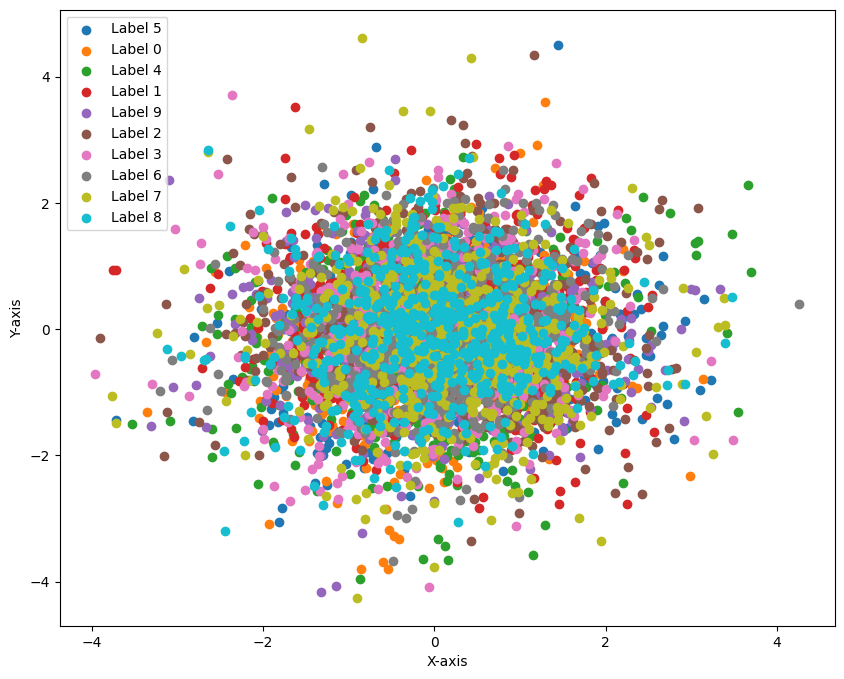

In [52]:
z_labels = {}
for z, label in zip(z_list, labels):
    if label not in z_labels:
        z_labels[label] = []
    z_labels[label].append(z)
    
colors = plt.cm.tab10.colors
plt.figure(figsize=(10, 8))
for label, color in zip(z_labels.keys(), colors):
    label_points = z_labels[label]
    x, y = zip(*label_points)
    plt.scatter(x, y, label=f'Label {label}', color=color)

# Set labels and show the plot
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()
plt.show()

**difference between VAE and CVAE distribution**

After training our VAE model, we then could visualize the latent variable space Q(z|X). In VAE, different classes are almost clustered and similar classes are near together and because Q(z|X) is continuous If we look closely on the reconstructed and generated data, we would notice that some of the data are ambiguous. For example the digit 5 looks like 3 or 8. In CVAE, things look messy, in contrast to VAE’s Q(z|X). But if we look at it closely, we could see that given a specific value of c=y, Q(z|X,c=y) is roughly N(0,1)! It’s because, if we look at our objective above, we are now modeling P(z|c), which we infer variationally with a N(0,1)